In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import metrics
from keras import regularizers
from keras.datasets import fashion_mnist
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

x_train = train_images[10000:]
x_validation = train_images[:10000]

y_train = train_labels[10000:]
y_validation = train_labels[:10000]

In [16]:
def create_model(activation='relu', regularizer=0.0):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1), kernel_regularizer=regularizers.L2(regularizer)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation=activation, kernel_regularizer=regularizers.L2(regularizer)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation=activation, kernel_regularizer=regularizers.L2(regularizer)),

        layers.Flatten(),
        layers.Dropout(0.5),

        layers.Dense(32, activation=activation, kernel_regularizer=regularizers.L2(regularizer)),
        # layers.Dropout(0.1),

        layers.Dense(10, activation="softmax")
    ])
    
    return model

In [18]:
activation = "leaky_relu"
regularizer=0.002

model = create_model(activation=activation, regularizer=regularizer)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# !rm -rf ./logs/fit/model_{activation}/reg_{regularizer}

# log_folder = f"./logs/fit/model_{activation}/reg_{regularizer}"
early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
# tensorboard = TensorBoard(log_dir=log_folder)

history = model.fit(
    x_train, 
    y_train, 
    epochs=200, 
    batch_size=1024,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpoint, early_stopping]

)
best_model = tf.keras.models.load_model('best_model.keras')
best_model.summary()
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test loss: {test_loss}, test accuracy: {test_accuracy}")

Epoch 1/200
49/49 [==============================] - ETA: 0s - loss: 1.6111 - accuracy: 0.5509
Epoch 1: val_accuracy improved from -inf to 0.74740, saving model to best_model.keras
49/49 [==============================] - 6s 61ms/step - loss: 1.6111 - accuracy: 0.5509 - val_loss: 0.9677 - val_accuracy: 0.7474
Epoch 2/200
49/49 [==============================] - ETA: 0s - loss: 0.9310 - accuracy: 0.7512
Epoch 2: val_accuracy improved from 0.74740 to 0.78810, saving model to best_model.keras
49/49 [==============================] - 2s 46ms/step - loss: 0.9310 - accuracy: 0.7512 - val_loss: 0.8093 - val_accuracy: 0.7881
Epoch 3/200
49/49 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.7822
Epoch 3: val_accuracy improved from 0.78810 to 0.81180, saving model to best_model.keras
49/49 [==============================] - 2s 48ms/step - loss: 0.8147 - accuracy: 0.7822 - val_loss: 0.7331 - val_accuracy: 0.8118
Epoch 4/200
49/49 [==============================] - ETA: 0s 

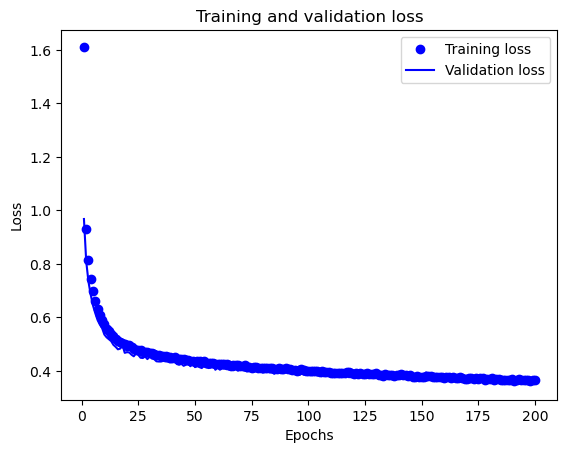

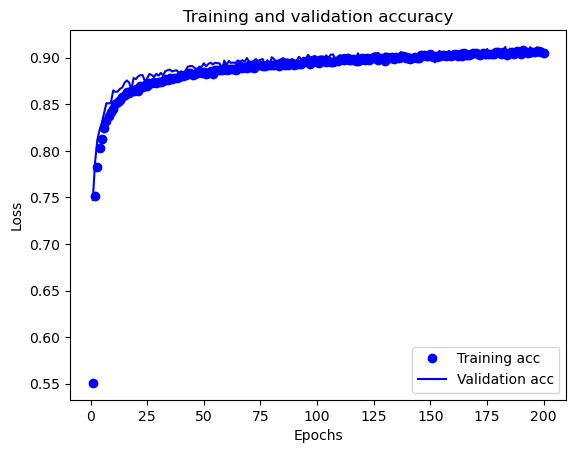

In [19]:
history = history.history
loss_values = history['loss']
val_loss_values = history['val_loss']

epochs = range(1, len(history['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss'),
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history['val_accuracy']
plt.plot(epochs, history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator


paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])
padded_image_train = tf.pad(train_images, paddings, "CONSTANT") 
padded_image_test = tf.pad(test_images, paddings, "CONSTANT") 


converted_train = tf.image.grayscale_to_rgb(padded_image_train)
converted_test = tf.image.grayscale_to_rgb(padded_image_test)


x_train = converted_train[10000:]
x_validation = converted_train[:10000]

y_train = train_labels[10000:]
y_validation = train_labels[:10000]


conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

modified_model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(512, activation="leaky_relu", kernel_regularizer=regularizers.L2(0.001)),
   layers.Dense(10, activation="sigmoid"),
])

early_stopping = EarlyStopping(patience=10, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model_vgg16.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

modified_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-5),
    # optimizer="adam",
    metrics=["accuracy"]
)

history = modified_model.fit(
    x_train, 
    y_train, 
    epochs=40,
    # batch_size=1024,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpoint, early_stopping]

)

test_loss, test_accuracy = modified_model.evaluate(converted_test, test_labels)
print(f"Test loss: {test_loss}, test accuracy: {test_accuracy}")


Epoch 1/40
1563/1563 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.8260
Epoch 1: val_accuracy improved from -inf to 0.87390, saving model to best_model_vgg16.keras
1563/1563 [==============================] - 60s 38ms/step - loss: 0.9803 - accuracy: 0.8260 - val_loss: 0.7942 - val_accuracy: 0.8739
Epoch 2/40
1563/1563 [==============================] - ETA: 0s - loss: 0.7558 - accuracy: 0.8815
Epoch 2: val_accuracy did not improve from 0.87390
1563/1563 [==============================] - 59s 37ms/step - loss: 0.7558 - accuracy: 0.8815 - val_loss: 0.7821 - val_accuracy: 0.8650
Epoch 3/40
1563/1563 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.8947
Epoch 3: val_accuracy improved from 0.87390 to 0.89000, saving model to best_model_vgg16.keras
1563/1563 [==============================] - 58s 37ms/step - loss: 0.6894 - accuracy: 0.8947 - val_loss: 0.6890 - val_accuracy: 0.8900
Epoch 4/40
1563/1563 [==============================] - ETA: 0s

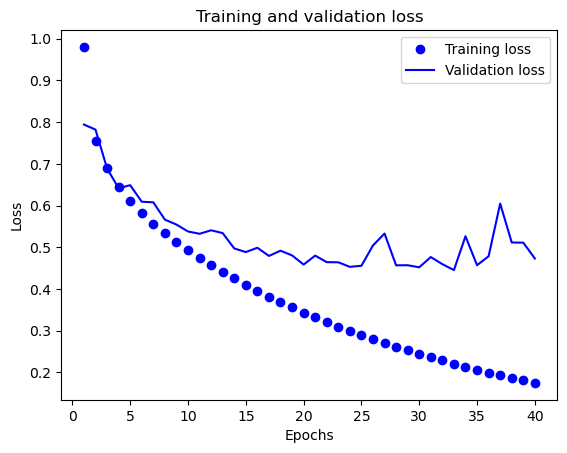

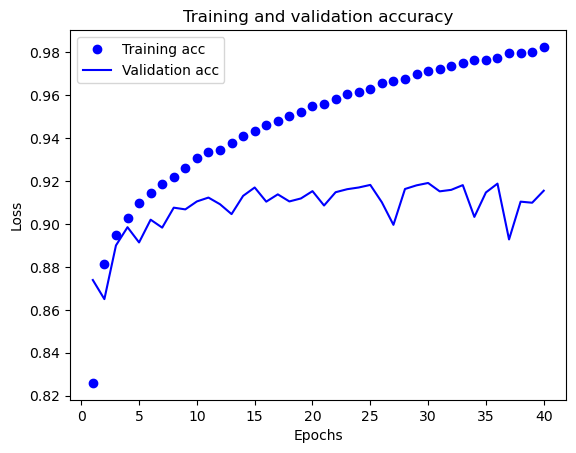

In [20]:
history = history.history
loss_values = history['loss']
val_loss_values = history['val_loss']

epochs = range(1, len(history['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history['val_accuracy']
plt.plot(epochs, history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
За допомогою згорткових мереж вдалось досягнути покращення з 0.896 до 0.91.